# Build an efficient supervised word translator

Based on : "Exploiting Similarities among Languages for Machine Translation" of Tomas Mikolov, Quoc V. Le & Ilya Sutskever (2013)

In [54]:
import io

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from statistics import stdev
import time
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.stats import special_ortho_group
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

In [41]:
# load function for pretrained versions of word embeddings
def load_embeddings(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [42]:
#eng_path = '/Users/louismonier/Downloads/Monolingual/wiki.en.vec' 
#fr_path = '/Users/louismonier/Downloads/Monolingual/wiki.fr.vec'

eng_path = '/Users/vince/DataProjetNLP/wiki.en.vec'
fr_path = '/Users/vince/DataProjetNLP/wiki.fr.vec'


nmax = 50000  # maximum number of word embeddings to load

# load monolingual word embeddings 
src_embeddings, src_id2word, src_word2id = load_embeddings(fr_path, nmax) # source = french 
tgt_embeddings, tgt_id2word, tgt_word2id = load_embeddings(eng_path, nmax) # target = english

### FRENCH to ENGLISH translation

* source language = french
* target language = english

In [43]:
# load ground-truth bilingual dictionaries function
def load_dic(path):
    dico_full = {}
    vectors_src=[]
    vectors_tgt = []
    with io.open(path,'r',encoding='utf_8') as f:
        for i,line in enumerate(f):
            word_src, word_tgt = line.rstrip().split(' ',1)
            if word_tgt in tgt_word2id :
                dico_full[word_src]=word_tgt
    for key in dico_full.keys() :
            vectors_src.append(src_embeddings[src_word2id[key]])
            vectors_tgt.append(tgt_embeddings[tgt_word2id[dico_full[key]]])
    X = np.vstack(vectors_src)
    Z = np.vstack (vectors_tgt)
    return dico_full,X,Z

In [44]:
# train & test bilingual dictionaries
path_train = '/Users/vince/DataProjetNLP/fr-en.0-5000.txt' 
path_test = '/Users/vince/DataProjetNLP/fr-en.5000-6500.txt'
dico_train, X_train, Z_train = load_dic(path_train)
dico_test, X_test, Z_test = load_dic(path_test) 

## Part I - Build a learning a linear mapping from a source (french) to a target (english) embedding space thanks to a translation Matrix W 

Suppose we are given a set of word pairs and their associated vector representations ${ \{x_i , z_i\} }^{n}_{i=1}$ , where $x_i$ ∈ $R^{d1}$ is the distributed representation of word i in the source language, and $z_i$ ∈ $R^{d2}$ is the vector representation of its translation.

It is our goal to find a transformation matrix W such that W xi approximates $z_i$ . In practice, W can be learned by the following optimization problem :

$$ \underset{W}{min} C (W) = \underset{W}{min} \sum_{i=1}^{n} \| W x_i - z_i \|^2 $$ 

which we solve with gradient descent (GD), stochastic gradient descent (SGD) or mini-batch gradient descent (BGD).

In [45]:
print(X_train.shape[0], "training samples")
print(X_test.shape[0], "test samples")

print("d1 dimension :", X_train.shape[1])
print("d2 dimension :", X_test.shape[1])

4971 training samples
1483 test samples
d1 dimension : 300
d2 dimension : 300


In [46]:
# function to minimize 
# normalisation added
def C(W,X,Z):
    S = 0
    S = sum(np.linalg.norm(np.dot(X, W.T) - Z, axis=1)**2) 
    return S

In [47]:
# gradient of the function to minimize
# normalisation added
def GradW(W,X,Z):
    G = np.zeros((Z_train.shape[1], X_train.shape[1]))
    G = 2*np.dot(X.T, (np.dot(X, W.T) - Z)).T
    return G

In [48]:
# GD function
def GradientDescent(eta, niter): 
    W = np.random.rand(Z_train.shape[1],Z_train.shape[1]) # random initialisation of W
    value_C = np.zeros(niter)
    
    for t in range(niter): 
        value_C[t] = (1/(X_train.shape[0])) * C(W,X_train,Z_train)
        W -= (1/X_train.shape[0])*eta*GradW(W,X_train,Z_train)
    print("GD done...")
    return (W, value_C) #,acc_test,acc_train)

In [49]:
# SGD function
def StochasticGradientDescent(eta, niter):
    W = np.random.rand(Z_train.shape[1],Z_train.shape[1]) # random initialisation of W
    grad = np.zeros((Z_train.shape[1], X_train.shape[1]))
    value_C = np.zeros(niter)
    
    for t in range(niter):
        rand_ind = np.random.randint(0, X_train.shape[0]) 
        X_i = X_train[rand_ind,:]
        Z_i = Z_train[rand_ind,:]    
        W -= eta*2*np.outer(X_i.T, (np.dot(X_i, W.T) - Z_i)).T   
        value_C[t] = np.linalg.norm(np.dot(W, X_i) - Z_i)**2
    print("SGD done...")
    return (W, value_C)

In [50]:
# BGD function
def BatchGradientDescent(eta, niter, batch_size):
    # initialisation
    N = X_train.shape[0]
    W = np.random.rand(Z_train.shape[1],Z_train.shape[1]) # random initialisation of W
    value_C = np.zeros(niter)
    for t in range(niter):
        l = np.random.choice(N,batch_size)
        grad = np.random.rand(Z_train.shape[1],Z_train.shape[1])
        cost = 0 
        for i in l:
            cost += np.linalg.norm(np.dot(W, X_train[i]) - Z_train[i])**2
            grad += 2*np.outer((np.dot(W, X_train[i]) - Z_train[i]), X_train[i])
        value_C[t] = (1/(batch_size)) * cost
        W -= eta*(1/(batch_size))*grad
    print("MGD done...")
    return (W, value_C)

### Train the model
The goal is to find the best W to map the source language to the target one.

In [51]:
eta_GD = 0.3
eta_SGD = 0.01
eta_BGD = 0.1
niter = 200

W_GD, C_GD = GradientDescent(eta_GD, niter) # GD
W_SGD, C_SGD = StochasticGradientDescent(eta_SGD, 2000) # SGD
W_BGD, C_BGD = BatchGradientDescent(eta_BGD, niter, 20) # BGD

GD done...
SGD done...
MGD done...


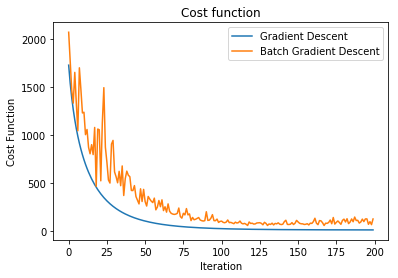

In [52]:
plt.plot(range(niter), C_GD, label="Gradient Descent")
#plt.plot(range(niter), C_SGD, label="Stochastic Gradient Descent")
plt.plot(range(niter), C_BGD, label="Batch Gradient Descent")
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
plt.title("Cost function")
plt.legend()
plt.show()

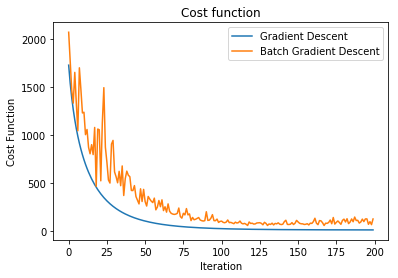

In [64]:
plt.plot(range(niter), C_GD, label="Gradient Descent")
#plt.plot(range(niter), C_SGD, label="Stochastic Gradient Descent")
plt.plot(range(niter), C_BGD, label="Batch Gradient Descent")
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
plt.title("Cost function")
plt.legend()
plt.show()


In [57]:
# Fastest training
Wmin = np.dot(np.linalg.pinv(X_train), Z_train).T 

### Testing the model

At the prediction time, for any given new word and its continuous vector representation x, we can map it to the other language space by computing $z = Wx$. Then, we find the word whose representation is closest to z in the target language space, using cosine similarity as the distance metric.

In [58]:
def prediction(W, new_word, k=5):
    x = src_embeddings[src_word2id[new_word]] # vector representation of new_word in the source space
    z = np.dot(W, x) # vector representation of the translated word in the target space

    # representation closest to z in the target language space, using cosine similarity as the distance metric
    z_pred1 = np.argmax(cosine_similarity(z.reshape(1,300),tgt_embeddings))

    # top k closest word embeddings in the target space
    z_predk = cosine_similarity(z.reshape(1,300),tgt_embeddings)[0].argsort()[-k:][::-1]
    
    return [tgt_id2word[z_pred1]], [tgt_id2word[z_predk[i]] for i in range(len(z_predk))]  # return the id of the translated word

In [59]:
# just a litte test
top1, top5 = prediction(W_GD, "bateau", k=5)
print("Top 1 translation for 'bateau' is :", top1)
print("Top 5 translations for 'bateau' are :", top5)

Top 1 translation for 'bateau' is : ['boat']
Top 5 translations for 'bateau' are : ['boat', 'boats', 'sailing', 'steamer', 'barge']


In [60]:
# construct a translation French to English dictionary
def prediction_dict(dico, W, kk):
    dico_pred1 = {}
    dico_predk = {}
    i = 0
    for word in dico.keys() :
        if (i%100==0):
            print("Progress :", round(i/len(dico_test)*100,1), "%")
        dico_pred1[word], dico_predk[word] = prediction(W, word, k) # lists
        i += 1
    print("Done...")
    return dico_pred1, dico_predk

In [61]:
# test predictions for W from GD

# k-top accuracy ("acc@k")
k = 5

dico_pred1, dico_predk = prediction_dict(dico_test, W_GD, k) 
dico_pred1_best, dico_predk_best = prediction_dict(dico_test, Wmin, k) 

Progress : 0.0 %
Progress : 6.7 %
Progress : 13.5 %
Progress : 20.2 %
Progress : 27.0 %
Progress : 33.7 %
Progress : 40.5 %
Progress : 47.2 %
Progress : 53.9 %
Progress : 60.7 %
Progress : 67.4 %
Progress : 74.2 %
Progress : 80.9 %
Progress : 87.7 %
Progress : 94.4 %
Done...
Progress : 0.0 %
Progress : 6.7 %
Progress : 13.5 %
Progress : 20.2 %
Progress : 27.0 %
Progress : 33.7 %
Progress : 40.5 %
Progress : 47.2 %
Progress : 53.9 %
Progress : 60.7 %
Progress : 67.4 %
Progress : 74.2 %
Progress : 80.9 %
Progress : 87.7 %
Progress : 94.4 %
Done...


In [28]:
# measure of the accuracy of the dictionnary
# output is a list
def accuracy(dpred1, dpredk, dico):
    acc1 = [0]
    acck = [0]
    
    for key in dico.keys():
        add1, addk = 0, 0
        
        if dico[key] == dpred1[key][0]:
            add1 = 1
        acc1.append(acc1[-1] + add1)  
    
        for i in np.arange(k):
            if dico[key] == dpredk[key][i]:
                addk = 1
                break   
        acck.append(acck[-1] + addk) 
    
    acc1 = [i/len(dico) for i in acc1]   
    acck = [i/len(dico) for i in acck]
    
    return acc1, acck # nb de mots bien prédits/nb de mots total     

In [29]:
acc1_test, acck_test = accuracy(dico_pred1, dico_predk, dico_test)
acc1_test_best, acck_test_best = accuracy(dico_pred1_best, dico_predk_best, dico_test)

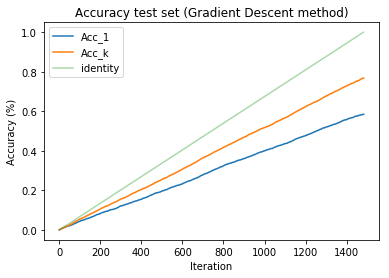

Gradient descent method :
Final accuracy @1 = 58.46 %
Final accuracy @5 = 76.8 %

Analytical method :
Final accuracy @1 = 60.22 %
Final accuracy @5 = 77.14 %


In [30]:
plt.plot(acc1_test, label="Acc_1")
plt.plot(acck_test,label="Acc_k")
plt.plot([i/len(dico_test) for i in range(len(dico_test))],label="identity",alpha=0.4)
plt.ylabel('Accuracy (%)')
plt.xlabel('Iteration')
plt.title("Accuracy test set (Gradient Descent method)")
plt.legend()
plt.show()

print("Gradient descent method :")
print("Final accuracy @1 =", round(acc1_test[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test[-1]*100, 2), "%")
print("")
print("Analytical method :")
print("Final accuracy @1 =", round(acc1_test_best[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test_best[-1]*100, 2), "%")

### Annex part I

GD done...
GD done...
GD done...
GD done...
GD done...
GD done...


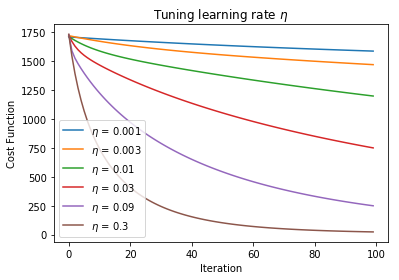

In [31]:
# GD hyper parameter sensitivity 
eta_list = np.array([0.001, 0.003, 0.01, 0.03, 0.09, 0.3]) 
niter = 100

plt.clf

for ieta in np.arange(0,eta_list.size):
    eta = eta_list[ieta]
    W_GD, C_GD = GradientDescent(eta, niter)
    plt.plot(C_GD, label='$\eta$ = %s' % eta_list[ieta])
    
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
plt.title("Tuning learning rate $\eta$")
plt.legend()

plt.show()

SGD done...
SGD done...
SGD done...


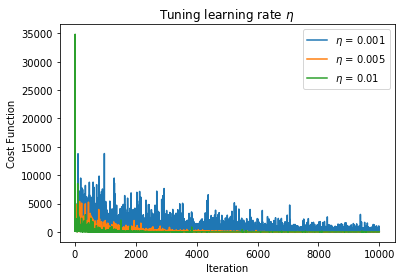

In [32]:
# SGD hyper parameter sensitivity 
eta_list = np.array([0.001, 0.005, 0.01])  #0.09, 0.3,0.03, 
niter = 10000

plt.clf

for ieta in np.arange(0,eta_list.size):
    eta = eta_list[ieta]
    W_SGD, C_SGD = StochasticGradientDescent(eta, niter)
    plt.plot(C_SGD, label='$\eta$ = %s' % eta_list[ieta])
    
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
plt.title("Tuning learning rate $\eta$")
plt.legend()

plt.show()

MGD done...
MGD done...
MGD done...
MGD done...


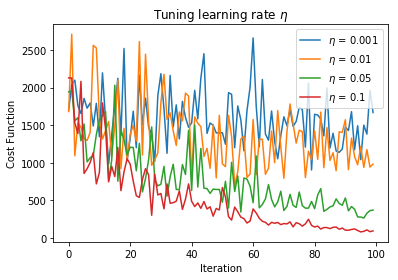

In [33]:
# BGD hyper parameter sensitivity
eta_list = np.array([0.001, 0.01, 0.05, 0.1])   
niter = 100
batch_size = 20

plt.clf

for ieta in np.arange(0,eta_list.size):
    eta = eta_list[ieta]
    W_BGD, C_BGD = BatchGradientDescent(eta, niter, batch_size)
    plt.plot(C_BGD, label='$\eta$ = %s' % eta_list[ieta])
    
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
plt.title("Tuning learning rate $\eta$")
plt.legend()

plt.show()

In [66]:
def CVGradientDescent(eta, eps): 
    start_time = time.time()
    W = np.random.rand(Z_train.shape[1],Z_train.shape[1]) # random initialisation of W
    value_C = []
    cost = (1/(X_train.shape[0])) * C(W,X_train,Z_train)
    value_C.append(cost)
    n_iter = 0
    
    while cost > eps:       
        W -= (1/X_train.shape[0])*eta*GradW(W,X_train,Z_train)
        cost = (1/(X_train.shape[0])) * C(W,X_train,Z_train)
        value_C.append(cost)
        n_iter += 1
        if stdev(value_C[-10:]) < 0.1:
            break
    exe = time.time() - start_time
    print("GD done...")
    return (n_iter, exe) 

In [67]:
def CVStochasticGradientDescent(eta, eps): 
    start_time = time.time()
    W = np.random.rand(Z_train.shape[1],Z_train.shape[1]) # random initialisation of W
    grad = np.zeros((Z_train.shape[1], X_train.shape[1]))
    value_C = []
    cost = (1/(X_train.shape[0])) * C(W,X_train,Z_train)
    cost_prec = 0.0
    value_C.append(cost)
    n_iter = 0
    
    while (cost > eps) and (abs(cost - cost_prec) > 0.1) :   
        rand_ind = np.random.randint(0, X_train.shape[0]) 
        X_i = X_train[rand_ind,:]
        Z_i = Z_train[rand_ind,:]    
        W -= eta*2*np.outer(X_i.T, (np.dot(X_i, W.T) - Z_i)).T   
        cost = np.linalg.norm(np.dot(W, X_i) - Z_i)**2
        cost_prec = value_C[-1]
        value_C.append(cost)
        n_iter += 1
        if stdev(value_C[-250:]) < 0.1:
            break
    exe = time.time() - start_time
    print("SGD done...")
    return (n_iter, exe, value_C) 

In [68]:
def CVBatchGradientDescent(eta, eps, batch_size): 
    start_time = time.time()
    N = X_train.shape[0]
    W = np.random.rand(Z_train.shape[1],Z_train.shape[1]) # random initialisation of W
    value_C = []
    rand_ind = np.random.randint(0, X_train.shape[0])
    cost = np.linalg.norm(np.dot(W, X_train[rand_ind]) - Z_train[rand_ind])**2
    value_C.append(cost)
    n_iter = 0
    
    while (cost > eps): #& (abs(cost - cost_prec) > 10):     
        l = np.random.choice(N,batch_size)
        grad = np.random.rand(Z_train.shape[1],Z_train.shape[1])
        cost = 0
        for i in l:
            cost += np.linalg.norm(np.dot(W, X_train[i]) - Z_train[i])**2
            grad += 2*np.outer((np.dot(W, X_train[i]) - Z_train[i]), X_train[i])
        cost = (1/batch_size) * cost
        cost_prec = value_C[-1]
        value_C.append(cost)
        W -= eta*(1/(batch_size))*grad 
        n_iter += 1

        if stdev(value_C[-10:]) < 0.01:
            break
    exe = time.time() - start_time
    print("BGD done...")
    return (n_iter, exe) 

In [69]:
# attention pas la même borne de cv...
niter_GD, exe_GD = CVGradientDescent(eta_GD, 5)
niter_SGD, exe_SGD, CSGD = CVStochasticGradientDescent(eta_SGD, 1e-3)
niter_BGD, exe_BGD = CVBatchGradientDescent(eta_BGD, 70, 20)

GD done...
SGD done...
BGD done...


SGD done...


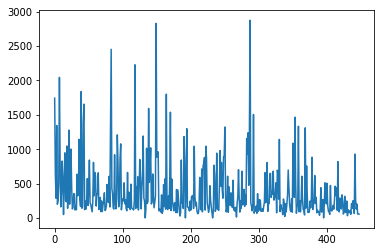

In [38]:
niter_SGD, exe_SGD, CC = CVStochasticGradientDescent(eta_SGD, 1e-3)
plt.plot(CC)

In [70]:
print("Temps d'éxécution jusqu'à cv :")
print(" GD : ", exe_GD, "s")
print(" SGD : ", exe_SGD, "s")
print(" BGD : ", exe_BGD, "s")
print("")
print("Temps d'éxécution / itération :")
print(" GD : ", (exe_GD*1e3)/niter_GD, "ms/ité")
print(" SGD : ", (exe_SGD*1e3)/niter_SGD, "ms/ité")
print(" BGD : ", (exe_BGD*1e3)/niter_BGD, "ms/ité")

Temps d'éxécution jusqu'à cv :
 GD :  15.712531089782715 s
 SGD :  1.9004881381988525 s
 BGD :  1.1685223579406738 s

Temps d'éxécution / itération :
 GD :  84.93260048531197 ms/ité
 SGD :  3.328350504726537 ms/ité
 BGD :  9.737686316172281 ms/ité


In [40]:

# BGD function
def BatchGradientDescent(eta, niter, batch_size):
    # initialisation
    N = X_train.shape[0]
    W = np.random.rand(Z_train.shape[1],Z_train.shape[1]) # random initialisation of W
    value_C = np.zeros(niter)
    for t in range(niter):
        l = np.random.choice(N,batch_size)
        grad = np.random.rand(Z_train.shape[1],Z_train.shape[1])
        cost = 0 
        for i in l:
            cost += np.linalg.norm(np.dot(W, X_train[i]) - Z_train[i])**2
            grad += 2*np.outer((np.dot(W, X_train[i]) - Z_train[i]), X_train[i])
        value_C[t] = (1/(batch_size)) * cost
        W -= eta*(1/(batch_size))*grad
    print("MGD done...")
    return (W, value_C)

## Part II - Adressing the inconsistency

Based on : 
* "Normalized Word Embedding and Orthogonal Transform for Bilingual Word Translation" of Chao Xing, Dong Wang, Chao Liu & Yiye Lin (2015)

(Xing et al. (2015) argued that Mikolov’s linear matrix should be orthogonal, and introduced an
approximate procedure composed of gradient descent updates and repeated applications of the SVD)

* "Offline bilingual word vectors, orthogonal transformations and the inverted softmax" of Samuel L. Smith, David H. P. Turban, Steven Hamblin & Nils Y. Hammerla


**Intuition :**
A self-consistent linear transformation between vector
spaces should be orthogonal. Intuitively, the transformation is a rotation, and it is found using the
singular value decomposition (SVD). The SVD aligns the translations remarkably well.



If $W$ maps the source language into the target, then $W^T$ maps the target language back into the source. Then, the transformation $W$ should be an orthogonal matrix $O$ satisfying $O^T O = Id$


So, we still try to minimize the following optimisation problem :
$$ \underset{W \in O_d (\mathbb{R})}{argmin} \sum_{i=1}^{n} \| W x_i - z_i \|^2 $$ 

Except, this time $W$ should be also an orthogonal matrix $O$. The problem can be rewritten as finding the maximum of : 

$$ \underset{O}{max} \sum_{i=1}^{n} z_i^T O x_i $$ 
With the orthogonal constraint ($Id$ is the identity matrix) : $$ O^T O = Id $$

The cost function is minimize by : 
$$ O = U V^T $$ 
Where $U$ and $V$ are obtained from SVD of $Y^T X$

In [41]:
# perform SVD
U, Sg, V = np.linalg.svd(np.dot(Z_train.T, X_train), full_matrices=True)
# compute the orthogonal translation matrix
O = np.matmul(U, V)

In [42]:
# just a litte test
top1, top5 = prediction(O, "arbre", k=5)
print("Top 1 translation for 'bateau' is :", top1)
print("Top 5 translations for 'bateau' are :", top5)
print("Works great !")

Top 1 translation for 'bateau' is : ['tree']
Top 5 translations for 'bateau' are : ['tree', 'trees', 'understory', 'bushes', 'canopy']
Works great !


In [43]:
dico_pred1_o, dico_predk_o = prediction_dict(dico_test, O, k) 

Progress : 0.0 %
Progress : 6.7 %
Progress : 13.5 %
Progress : 20.2 %
Progress : 27.0 %
Progress : 33.7 %
Progress : 40.5 %
Progress : 47.2 %
Progress : 53.9 %
Progress : 60.7 %
Progress : 67.4 %
Progress : 74.2 %
Progress : 80.9 %
Progress : 87.7 %
Progress : 94.4 %
Done...


In [44]:
acc1_test_o, acck_test_o = accuracy(dico_pred1_o, dico_predk_o, dico_test)

In [45]:
print("Gradient descent method :")
print("Final accuracy @1 =", round(acc1_test[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test[-1]*100, 2), "%")
print("")
print("Orthogonal method :")
print("Final accuracy @1 =", round(acc1_test_o[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test_o[-1]*100, 2), "%")
print("")
print("Analytical method :")
print("Final accuracy @1 =", round(acc1_test_best[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test_best[-1]*100, 2), "%")

Gradient descent method :
Final accuracy @1 = 58.46 %
Final accuracy @5 = 76.8 %

Orthogonal method :
Final accuracy @1 = 62.58 %
Final accuracy @5 = 78.96 %

Analytical method :
Final accuracy @1 = 60.22 %
Final accuracy @5 = 77.14 %


### PCA

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space with Translation matrix')

    plt.show()

Variance explained: 0.10


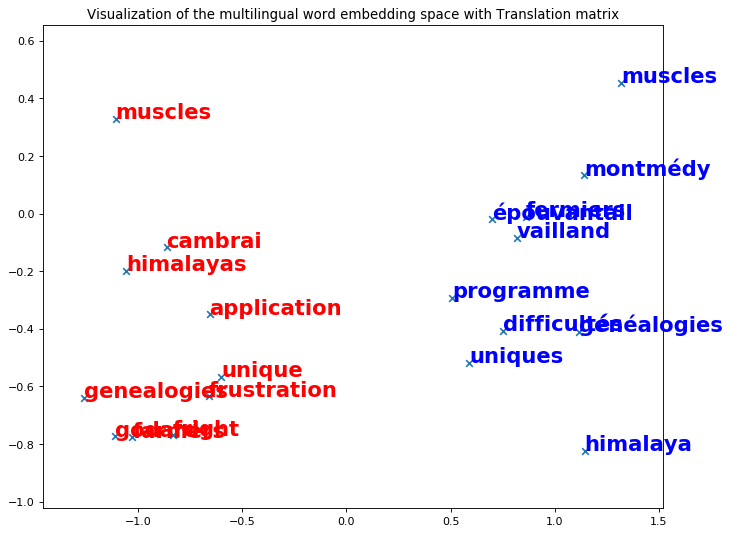

In [47]:
import random
src_words = random.sample(list(src_word2id.keys()), 10)
#src_words = ['bateau', 'maison', 'argent', 'ordinateur', 'dieu']
tgt_words = []
for i in range(0,len(src_words)):
    top1, top5 = prediction(W_GD, src_words[i], k=5) #top 1: english word (target)
    tgt_words.append(top1[0])

# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)

# Training on ohter language

Once we know that the code works for a translator french to english, we can test its adaptability on other laguages. Here we are going to implement the same method but for italian to english translator 

In [33]:
#try with italian and chinese
ch_path = '/Users/vince/DataProjetNLP/wiki.zh_yue.vec'
it_path = '/Users/vince/DataProjetNLP/wiki.it.vec'

nmax = 50000  # maximum number of word embeddings to load


# load monolingual word embeddings 
it_embeddings, it_id2word, it_word2id = load_embeddings(it_path, nmax) 

In [34]:
# load ground-truth bilingual dictionaries function
def load_dic_ch(path):
    dico_train = {}
    dico_test = {}
    vectors_src_train=[]
    vectors_tgt_train = []
    vectors_src_test = []
    vectors_tgt_test = []
    with io.open(path,'r',encoding='utf_8') as f:
        for i,line in enumerate(f):
            if (i>3000):
                word_src, word_tgt = line.rstrip().split(' ',1)
                if word_tgt in it_word2id :
                    dico_train[word_src]=word_tgt
            else :
                word_src, word_tgt = line.rstrip().split(' ',1)
                if word_tgt in it_word2id :
                    dico_test[word_src]=word_tgt
                    
    for key in dico_train.keys() :
            try :
                a = it_embeddings[it_word2id[key]]
          #      try :
                b = tgt_embeddings[tgt_word2id[dico_train[key]]]
                vectors_src_train.append(a)
                vectors_tgt_train.append(b)
          #  except :
               #     print("unkown word")
            except :
                print("unkown word")
                
         
    for key in dico_test.keys() :
            try :
                vectors_src_test.append(it_embeddings[it_word2id[key]])
                vectors_tgt_test.append(tgt_embeddings[tgt_word2id[dico_test[key]]])
            except :
                print("unkown word")
                           
                
    X_train = np.vstack(vectors_src_train)
    Z_train = np.vstack (vectors_tgt_train)
    X_test = np.vstack(vectors_src_test)
    Z_test = np.vstack (vectors_tgt_test)
    return dico_train,dico_test,X_train,X_test,Z_train,Z_test

In [6]:
# train & test bilingual dictionaries
path_train = '/Users/vince/DataProjetNLP/it-en.txt'
dico_train,dico_test, X_train,X_test, Z_train, Z_test= load_dic_ch(path_train)

unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unko

unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unko

unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unkown word
unko

In [7]:
print(len(dico_train),len(dico_test))

20587 1708


In [8]:
# Fastest training
Wmin = np.dot(np.linalg.pinv(X_train), Z_train).T 

In [9]:
def prediction_it(W, new_word, k=5):
    
    x = it_embeddings[it_word2id[new_word]] # vector representation of new_word in the source space
    z = np.dot(W, x) # vector representation of the translated word in the target space

    # representation closest to z in the target language space, using cosine similarity as the distance metric
    z_pred1 = np.argmax(cosine_similarity(z.reshape(1,300),tgt_embeddings))

    # top k closest word embeddings in the target space
    z_predk = cosine_similarity(z.reshape(1,300),tgt_embeddings)[0].argsort()[-k:][::-1]
    
    return [tgt_id2word[z_pred1]], [tgt_id2word[z_predk[i]] for i in range(len(z_predk))]  # return the id of the translated word

In [10]:
# construct a translation French to English dictionary
def prediction_dict_it(dico, W, k):
    dico_pred1 = {}
    dico_predk = {}
    i = 0
    for word in dico.keys() :
        if (i%100==0):
            print("Progress :", round(i/len(dico_test)*100,1), "%")
        try  :
            dico_pred1[word], dico_predk[word] = prediction_it(W, word, k) # lists
        except :
            print("unknown word")
        i += 1
    print("Done...")
    return dico_pred1, dico_predk

In [11]:
dico_pred1, dico_predk = prediction_dict_it(dico_test, Wmin, 5) 

Progress : 0.0 %
Progress : 5.9 %
Progress : 11.7 %
Progress : 17.6 %
Progress : 23.4 %
Progress : 29.3 %
Progress : 35.1 %
Progress : 41.0 %
Progress : 46.8 %
Progress : 52.7 %
Progress : 58.5 %
Progress : 64.4 %
Progress : 70.3 %
Progress : 76.1 %
Progress : 82.0 %
Progress : 87.8 %
Progress : 93.7 %
Progress : 99.5 %
Done...


In [36]:
# measure of the accuracy of the dictionnary
# output is a list
def accuracy_it(dpred1, dpredk, dico):
    acc1 = [0]
    acck = [0]
    
    for key in dico.keys():
        add1, addk = 0, 0
        try : 
            if dico[key] == dpred1[key][0]:
                add1 = 1
                #print("success")
        except :
            continue
            #print("unkown word")
        acc1.append(acc1[-1] + add1)  
        for i in np.arange(5):
            try :
                if dico[key] == dpredk[key][i]:
                    addk = 1
                    #print("success2")
                    break 
            except :
                continue
                #print("unkown word")
        acck.append(acck[-1] + addk) 

    acc1 = [i/len(dico) for i in acc1]   
    acck = [i/len(dico) for i in acck]
    
    return acc1, acck # nb de mots bien prédits/nb de mots total     

In [37]:
acc1_test, acck_test = accuracy_it(dico_pred1, dico_predk, dico_test)
#acc1_test_best, acck_test_best = accuracy_it(dico_pred1_best, dico_predk_best, dico_test)

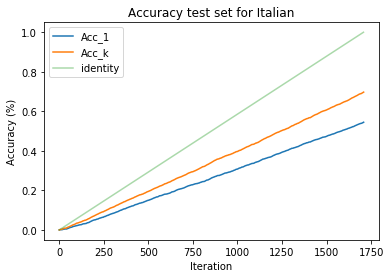

Gradient descent method :
Final accuracy @1 = 54.45 %
Final accuracy @5 = 69.67 %


In [38]:
plt.plot(acc1_test, label="Acc_1")
plt.plot(acck_test,label="Acc_k")
plt.plot([i/len(dico_test) for i in range(len(dico_test))],label="identity",alpha=0.4)
plt.ylabel('Accuracy (%)')
plt.xlabel('Iteration')
plt.title("Accuracy test set for Italian")
plt.legend()
plt.show()

print("Gradient descent method :")
print("Final accuracy @1 =", round(acc1_test[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test[-1]*100, 2), "%")

## Build the discriminator 

Recall what is the objective of the discriminator here : ...

In [7]:
class Discriminator(nn.Module):
    def __init__(self, dim):
        super(Discriminator,self).__init__()
        self.h1 = nn.Linear(dim, 2048,bias=True) # 1st hidden layer
        #self.h2 = nn.Linear(2048,2048,bias=True) # 2nd hidden layer
        self.out = nn.Linear(2048,1,bias=True) # output layer
        
    def forward(self, x):
        x = F.dropout(x, p = 0.1) # dropout pour ajouter du bruit
        x = F.leaky_relu(self.h1(x)) #, negative_slope=0.2)
        #x = F.leaky_relu(self.h2(x), negative_slope=0.2)
        y = torch.sigmoid(self.out(x)) # ouput = proba
        return y

## Build the generator 

Recall what is the objective of the discriminator here : ...

In [8]:
# simple linear function 
# can be seen at a neural network whose weights are elements of W 
class Generator(nn.Module):
    def __init__(self, dim):
        super(Generator, self).__init__()
        self.l1 = nn.Linear(dim, dim, bias=False)

    def forward(self,x):
        y = self.l1(x)
        return y

## It's time to train 

In [9]:
discrim = Discriminator(dim)
gener = Generator(dim)

In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

optimizerD = optim.SGD(discrim.parameters(), lr=0.1)
optimizerG = optim.SGD(gener.parameters(), lr=0.1)

In [11]:
#for epoch in range(3): #3 Epochs 
G_losses = []
D_losses = []
iters = 0

N = 16 # nb of "fake" tgt // Wx
M = 16 # nb of "true" tgt // y

W = special_ortho_group.rvs(dim) #np.zeros((300,300), dtype=float)  #np.random.rand(Z_train.shape[1],Z_train.shape[1]) #  # #
gener.l1.weight.data = torch.tensor(W,dtype=torch.float) # ini of generator's weights in SO(300)
beta = 0.01

for param in discrim.h1.parameters():
    param.data.normal_(0.0, 0.2) #uniform_(-0.1,0.1)

niter = 1000
num_epochs = 5
#nb_d = 1
#nb_g = 10

# Establish convention for real and fake labels during training
real_label = 0.8
fake_label = 0.2

In [13]:
print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i in range(niter):
        
        ###############################################################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))) #
        ###############################################################
        
        ## Train with all-real batch
        discrim.zero_grad()
        # Format batch : generate M random words from the target
        
        rand_tgt_word_id = torch.Tensor(M).random_(X_train.shape[0]).long()
        tgt_word_emb = Z_train[rand_tgt_word_id.numpy()]
        tgt_word_emb = torch.tensor(tgt_word_emb, dtype=torch.float) # conversion to tensor

        label = torch.full((M,1), real_label)
        
        # Forward pass real batch through D
        output = discrim(tgt_word_emb)#.view(-1)
        #print(output.shape)
        #print(output.view(-1).shape)
        
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        
        ## create a new batch of N fake & M true data to train the discriminator
        # generate N random words from the source 
        rand_src_word_id = torch.Tensor(N).random_(X_train.shape[0]).long()
        src_word_emb = X_train[rand_src_word_id.numpy()]
        noise = torch.tensor(src_word_emb, dtype=torch.float) # conversion to tensor
        
        # Generate fake tgt batch with G
        fake = gener(noise)
        
        label.fill_(fake_label)  
        # Classify all fake batch with D
        output = discrim(fake.detach())#.view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        gener.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discrim(fake)#.view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()

        # Update G
        optimizerG.step()
        
        W_trained = gener.l1.weight.data # get the weights of the generator which are the elements of W
        # to ensure that the matrix stays close to the manifold of orthogonal matrices after each update
        W_ortho = (1+beta)*W_trained - beta*torch.mm(torch.mm(W_trained, W_trained.t()), W_trained) 
        gener.l1.weight.data = W_ortho 
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, niter,
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

Starting Training Loop...
[0/5][0/1000]	Loss_D: 1.4459	Loss_G: 2.1406	D(x): 0.4791	D(G(z)): 0.5109 / 0.0819


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[0/5][50/1000]	Loss_D: 16.3349	Loss_G: 7.8043	D(x): 0.9998	D(G(z)): 1.0000 / 0.0040
[0/5][100/1000]	Loss_D: 8.1192	Loss_G: 6.6719	D(x): 0.9931	D(G(z)): 0.9996 / 0.0006
[0/5][150/1000]	Loss_D: 5.3676	Loss_G: 5.4549	D(x): 0.9361	D(G(z)): 0.9917 / 0.0021
[0/5][200/1000]	Loss_D: 3.4546	Loss_G: 3.1207	D(x): 0.8264	D(G(z)): 0.9551 / 0.0299
[0/5][250/1000]	Loss_D: 3.3459	Loss_G: 0.7574	D(x): 0.0527	D(G(z)): 0.1685 / 0.9444
[0/5][300/1000]	Loss_D: 3.3985	Loss_G: 0.7100	D(x): 0.0599	D(G(z)): 0.2277 / 0.9172
[0/5][350/1000]	Loss_D: 2.2197	Loss_G: 0.5495	D(x): 0.2185	D(G(z)): 0.3511 / 0.8380
[0/5][400/1000]	Loss_D: 2.2148	Loss_G: 0.5602	D(x): 0.2355	D(G(z)): 0.4728 / 0.6748
[0/5][450/1000]	Loss_D: 1.9373	Loss_G: 0.5358	D(x): 0.2455	D(G(z)): 0.3090 / 0.7295
[0/5][500/1000]	Loss_D: 1.6291	Loss_G: 1.9228	D(x): 0.7072	D(G(z)): 0.6858 / 0.1394
[0/5][550/1000]	Loss_D: 1.8072	Loss_G: 2.4322	D(x): 0.5981	D(G(z)): 0.7374 / 0.0683
[0/5][600/1000]	Loss_D: 1.9643	Loss_G: 2.3997	D(x): 0.6289	D(G(z)): 0.7793 /

[4/5][950/1000]	Loss_D: 1.4325	Loss_G: 0.7975	D(x): 0.5545	D(G(z)): 0.5624 / 0.4368


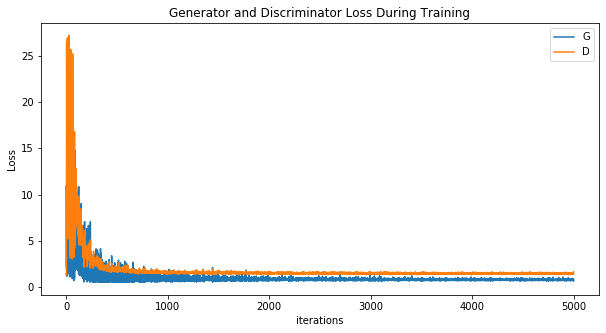

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Tests

In [16]:
def prediction(W, new_word, k=5):
    x = src_embeddings[src_word2id[new_word]] # embedding on of new_word in the source space
    z = np.dot(W, x) # embedding of the translated word in the target space

    # representation closest to z in the target language space, using cosine similarity as the distance metric
    z_pred1 = np.argmax(cosine_similarity(z.reshape(1,300), tgt_embeddings))

    # top k closest word embeddings in the target space
    z_predk = cosine_similarity(z.reshape(1,300), tgt_embeddings)[0].argsort()[-k:][::-1]
    
    return [tgt_id2word[z_pred1]], [tgt_id2word[z_predk[i]] for i in range(len(z_predk))]  # return the id of the translated word

In [17]:
W_trained_test = gener.l1.weight.data
print(W_trained_test[:3,:3])

tensor([[ 0.0372,  0.0441,  0.0013],
        [-0.0288,  0.0582, -0.0241],
        [-0.0095, -0.1309,  0.0246]])


In [18]:
# just a litte test
top1, top5 = prediction(W_trained_test, "bateau", k=5)
print("Top 1 translation for 'bateau' is :", top1)
print("Top 5 translations for 'bateau' are :", top5)

Top 1 translation for 'bateau' is : ['ever']
Top 5 translations for 'bateau' are : ['ever', 'champions', 'technologically', 'championship', 'materially']


In [19]:
src_words = ['bateau', 'maison', 'argent', 'ordinateur', 'dieu']
tgt_words = []
for i in range(0,len(src_words)):
    top1, top5 = prediction(W_trained_test.numpy(), src_words[i], k=5) #top 1: english word (target)
    tgt_words.append(top1[0])
    print(top5)
    print('--')

['ever', 'champions', 'technologically', 'championship', 'materially']
--
['loggins', 'brecker', 'flanagan', 'kelly', 'brubeck']
--
['methodist', 'promptly', 'carl', 'methodism', 'likewise']
--
['annoy', 'so', 'piss', 'hurting', 'therefore']
--
['glad', 'regret', 'adamant', 'commented', 'terrific']
--


In [ ]:
# functions of accuracy = 
# - Test how far we are from the "supposed" translation
# compute Wxi find the closest z (SUPPOSED TO BE ITS TRANSLATION) and cumpute eculidian distance
def test_accuracy(X_text,W_trained):
    loss = 0
    for x in X_test : # get all french words
        word2id = {v: k for k, v in src_id2word.items()}
        word_emb_new = np.dot(W_trained, x)
        scores = (tgt_embeddings / np.linalg.norm(tgt_embeddings, 2, 1)[:, None]).dot(word_emb_new / np.linalg.norm(word_emb_new))
        best = scores.argsort()[-1:][::-1]
        nearest_eng_emb = src_embeddings[best]
        loss = loss + np.linalg.norm(word_emb_new-nearest_eng_emb)  
    return(loss)
    


In [ ]:
rand_test_word_id = torch.Tensor(30).random_(nmax).long()
X_test = src_embeddings[rand_test_word_id.numpy()] # GARDER LES MEMES POUR LES TESTS

test_accuracy(X_test,W_trained_test)

In [ ]:
# construct a translation French to English dictionary
def prediction_dict(dico, W, k):
    dico_pred1 = {}
    dico_predk = {}
    i = 0
    for word in dico.keys() :
        if (i%100==0):
            print("Progress :", round(i/len(dico_test)*100,1), "%")
        dico_pred1[word], dico_predk[word] = prediction(W, word, k) # lists
        i += 1
    print("Done...")
    return dico_pred1, dico_predk

In [ ]:
# k-top accuracy ("acc@k")
k = 5

dico_pred1, dico_predk = prediction_dict(dico_test, W_trained_test, k) 

In [ ]:
# measure of the accuracy of the dictionnary
# output is a list
def accuracy(dpred1, dpredk, dico):
    acc1 = [0]
    acck = [0]
    
    for key in dico.keys():
        add1, addk = 0, 0
        
        if dico[key] == dpred1[key][0]:
            add1 = 1
        acc1.append(acc1[-1] + add1)  
    
        for i in np.arange(k):
            if dico[key] == dpredk[key][i]:
                addk = 1
                break   
        acck.append(acck[-1] + addk) 
    
    acc1 = [i/len(dico) for i in acc1]   
    acck = [i/len(dico) for i in acck]
    
    return acc1, acck # nb de mots bien prédits/nb de mots total     

In [ ]:
acc1_test, acck_test = accuracy(dico_pred1, dico_predk, dico_test)

In [ ]:
plt.plot(acc1_test, label="Acc_1")
plt.plot(acck_test,label="Acc_k")
plt.plot([i/len(dico_test) for i in range(len(dico_test))],label="identity",alpha=0.4)
plt.ylabel('Accuracy (%)')
plt.xlabel('Iteration')
plt.title("Accuracy test set (Gradient Descent method)")
plt.legend()
plt.show()

print("Gradient descent method :")
print("Final accuracy @1 =", round(acc1_test[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test[-1]*100, 2), "%")

## How to pair words

CSLS tentative

In [ ]:
k = 5 # hyper parameter K-NN
CSLS = np.zeros(nmax)

def CSLS_measure(W, new_word, k):
    x = src_embeddings[src_word2id[new_word]] # embeddings of new_word in the source space
    z = np.dot(W, x).reshape(-1,300) # embeddings of the translated word in the target space
    
    knn = NearestNeighbors(n_neighbors=k, algorithm='auto')
    for t in range(tgt_embeddings.shape[0]):
        dist_tgt_nn_z, index_tgt_nn_z = knn.kneighbors(z)
        emb_tgt_nn_z = tgt_embeddings[index_tgt_nn_z[0][:]].reshape(-1,300) # embeddings of the k-nn in the tgt space
        r_T = (1/k)*sum(cosine_similarity(z, emb_tgt_nn_z))
        
        dist_tgt_nn_yt, index_tgt_nn_yt = knn.kneighbors(tgt_embeddings[t])
        emb_tgt_nn_yt = tgt_embeddings[index_tgt_nn_yt[0][:]].reshape(-1,300) 
        r_S = (1/k)*sum(cosine_similarity(tgt_embeddings[t], emb_tgt_nn_yt))
        
        CSLS[t] = 2*cosine_similarity(z, tgt_embeddings[t]) - r_T - r_S
    CSLS = np.argmax(CSLS)
        
    return CSLS